In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Load datasets
housing_data = pd.read_csv('housing_economic_data_2002_2023.csv')
all_consumer_trends = pd.ExcelFile('consumertrendsq42022cpnsa.xls')

# Select relevant columns from all_consumer_trends
major_trends = pd.read_excel(all_consumer_trends, sheet_name = '04CN')
minor_trends = pd.read_excel(all_consumer_trends, sheet_name = '05CN', usecols=['Date', 'Furnishing, household equipment and routine HH maintenance', 'Furniture and furnishings, carpets and other floor coverings', 'Household appliances', 'Repair of household appliances','Goods and services for routine household maintenance' ])

# Extract only columns 'Date' and 'Actual rentals paid by tenants' from the 'major_costs_O4CN'
df_rents = major_trends[['Date', 'Actual rentals paid by tenants']]

In [20]:
'''
Preprocessing the input dataframes by cleaning, 
converting date formats to quarterly date, 
aladjusting the start dates to '2002 Q1' to '2022 Q4', 
and removing duplicates and missing values.  
'''
# Cleaning the datasets date formats
# Convert the 'Date' column to datetime format
housing_data['Date'] = pd.to_datetime(housing_data['Date'])

# Select only the last date of each quarter
housing_df = housing_data[housing_data['Date'].dt.is_quarter_end]

# Convert the 'Date' column to the format 'YYYY Qn'
housing_df['Date'] = housing_df['Date'].dt.to_period('Q').astype(str)
housing_df['Date'] = housing_df['Date'].str.replace('Q', ' Q')

# Select the data from all dataset only after 2002 Q1 to 2022 Q4
df_housing = housing_df.iloc[:84]
rents = df_rents.iloc[20:]
df_trends = minor_trends.iloc[20:]

C:\Users\mehrd\AppData\Local\Temp\ipykernel_24956\890541230.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df['Date'] = housing_df['Date'].dt.to_period('Q').astype(str)
C:\Users\mehrd\AppData\Local\Temp\ipykernel_24956\890541230.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df['Date'] = housing_df['Date'].str.replace('Q', ' Q')


--------------

#
### Data Exploration, Cleaning, and Preparation

In [21]:
# Understand the dataframes
print(df_housing.columns)
print(rents.columns)
print(df_trends)

Index(['Date', 'Housing Cost Index', 'Interest Rate (%)', 'Inflation Rate (%)',
       'Employment Levels (000s)', 'Growth in Wage (%)',
       'GDP Growth Rate (%)'],
      dtype='object')
Index(['Date', 'Actual rentals paid by tenants'], dtype='object')
        Date  Furnishing, household equipment and routine HH maintenance  \
20   2002 Q1                                              10216            
21   2002 Q2                                              10033            
22   2002 Q3                                              10139            
23   2002 Q4                                              11807            
24   2003 Q1                                              10003            
..       ...                                                ...            
99   2021 Q4                                              20868            
100  2022 Q1                                              18308            
101  2022 Q2                                              18

In [22]:
'''
Merging dataframes into one dataframe for data analysis and training the model.
Dataframes: df_housing (all columns), df_trends(only date, Furnishing, household equipment and routine HH maintenance, and good and services for routine household), and rents(only date, and actual rentals paid by tenants)
'''

# Merge df_housing and df_trends on 'Date'
df_temp = pd.merge(df_housing[['Date', 'Housing Cost Index', 'Interest Rate (%)', 'Inflation Rate (%)', 'Employment Levels (000s)', 'Growth in Wage (%)', 'GDP Growth Rate (%)']], df_trends[['Date','Furnishing, household equipment and routine HH maintenance', 'Goods and services for routine household maintenance']], on='Date')

# Merge the result with rents on 'Date'
df_merged = pd.merge(df_temp, rents[['Date', 'Actual rentals paid by tenants']], on='Date')

In [23]:
# Check and drop the null values
df_merged.isnull().sum()
df_merged.dropna

<bound method DataFrame.dropna of        Date  Housing Cost Index  Interest Rate (%)  Inflation Rate (%)  \
0   2002 Q1          315.092076           2.691776            3.013669   
1   2002 Q2          630.913169           0.749172            4.197642   
2   2002 Q3          959.070766           3.267249            4.494314   
3   2002 Q4         1253.271955           1.396139            2.107511   
4   2003 Q1         1502.328418           0.645812            1.738084   
..      ...                 ...                ...                 ...   
79  2021 Q4        23991.351374           5.890179            2.658496   
80  2022 Q1        24285.317325           3.983705            3.008780   
81  2022 Q2        24575.281688           1.208838            3.999842   
82  2022 Q3        24884.839384           1.263549            1.820559   
83  2022 Q4        25185.768779           2.401170            2.888268   

    Employment Levels (000s)  Growth in Wage (%)  GDP Growth Rate (%)  \
0   

In [24]:
# Check for duplicates
df_merged.duplicated().sum()

0

In [25]:
# Understand the first tuples
df_merged.head()

,Date,Housing Cost Index,Interest Rate (%),Inflation Rate (%),Employment Levels (000s),Growth in Wage (%),GDP Growth Rate (%),"Furnishing, household equipment and routine HH maintenance",Goods and services for routine household maintenance,Actual rentals paid by tenants
0,2002 Q1,315.092076,2.691776,3.013669,31439.995432,6.256035,-0.830707,10216,1625,7293
1,2002 Q2,630.913169,0.749172,4.197642,26561.525974,4.962039,3.154814,10033,1809,7558
2,2002 Q3,959.070766,3.267249,4.494314,25270.959925,5.390081,3.909193,10139,1751,7828
3,2002 Q4,1253.271955,1.396139,2.107511,31718.927436,6.393150,4.077899,11807,1707,8095
4,2003 Q1,1502.328418,0.645812,1.738084,32999.160854,6.252909,-0.111753,10003,1573,8253


In [26]:
# Understand the last tuples
df_merged.tail()

,Date,Housing Cost Index,Interest Rate (%),Inflation Rate (%),Employment Levels (000s),Growth in Wage (%),GDP Growth Rate (%),"Furnishing, household equipment and routine HH maintenance",Goods and services for routine household maintenance,Actual rentals paid by tenants
79,2021 Q4,23991.351374,5.890179,2.658496,26538.959063,4.461389,-0.933088,20868,2854,21984
80,2022 Q1,24285.317325,3.983705,3.008780,27238.176148,4.226526,1.779700,18308,2686,22074
81,2022 Q2,24575.281688,1.208838,3.999842,30800.862078,4.964754,2.365100,18771,2923,22262
82,2022 Q3,24884.839384,1.263549,1.820559,27656.000426,6.847062,-1.106006,18402,2898,22453
83,2022 Q4,25185.768779,2.401170,2.888268,34556.514982,3.625950,2.961213,21371,2841,22639


#
### Data Exploration

In [27]:
# Explore the information 
df_merged.describe()

,Housing Cost Index,Interest Rate (%),Inflation Rate (%),Employment Levels (000s),Growth in Wage (%),GDP Growth Rate (%),"Furnishing, household equipment and routine HH maintenance",Goods and services for routine household maintenance,Actual rentals paid by tenants
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,12650.818147,3.125812,2.852353,29667.019678,4.727413,1.711217,13330.404762,2251.166667,15777.654762
std,7331.102481,1.768212,1.077995,3108.747636,1.518123,2.084875,2892.766863,434.140276,5059.394210
min,315.092076,0.559607,1.018528,25178.739347,2.048854,-1.820506,9937.000000,1573.000000,7293.000000
25%,6370.184554,1.362992,1.878954,27231.655716,3.422428,-0.346986,11152.500000,1902.250000,11114.000000
50%,12636.465338,3.010183,2.869493,29073.821527,5.045441,2.266101,12322.500000,2142.000000,16435.000000
75%,18899.438552,4.945932,3.685032,32280.834828,6.028103,3.232030,15327.250000,2662.000000,20648.500000
max,25185.768779,5.930019,4.737468,34911.686261,6.933313,4.958976,21371.000000,3209.000000,22639.000000


                                                    Actual rentals paid by tenants  \
Actual rentals paid by tenants                                            1.000000   
Housing Cost Index                                                        0.986239   
Interest Rate (%)                                                         0.214782   
Inflation Rate (%)                                                       -0.015096   
Employment Levels (000s)                                                 -0.027147   
Growth in Wage (%)                                                       -0.078523   
GDP Growth Rate (%)                                                      -0.130905   
Goods and services for routine household mainte...                        0.899083   

                                                    Housing Cost Index  \
Actual rentals paid by tenants                                0.986239   
Housing Cost Index                                            1.000000   
Int

<Axes: >

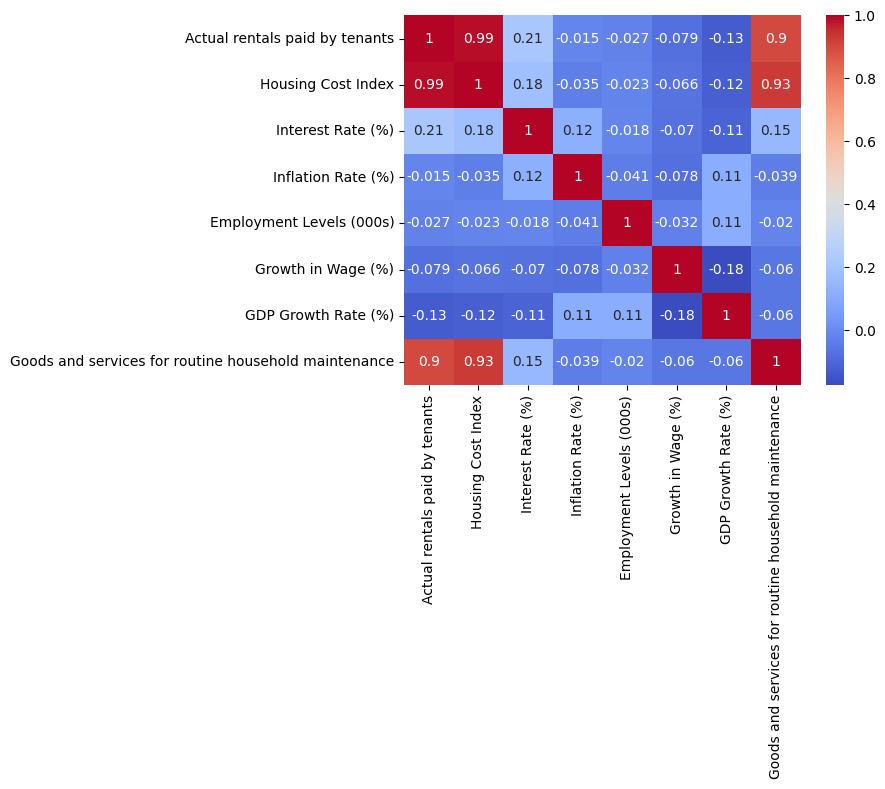

In [28]:
# Create a dataframe(without Object type values) for understanding the correlations
df_merged_no_Date = df_merged[['Actual rentals paid by tenants', 'Housing Cost Index', 'Interest Rate (%)', 'Inflation Rate (%)', 'Employment Levels (000s)', 'Growth in Wage (%)', 'GDP Growth Rate (%)','Goods and services for routine household maintenance']]
# Create a correlation matrix
correlation_matrix = df_merged_no_Date.corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

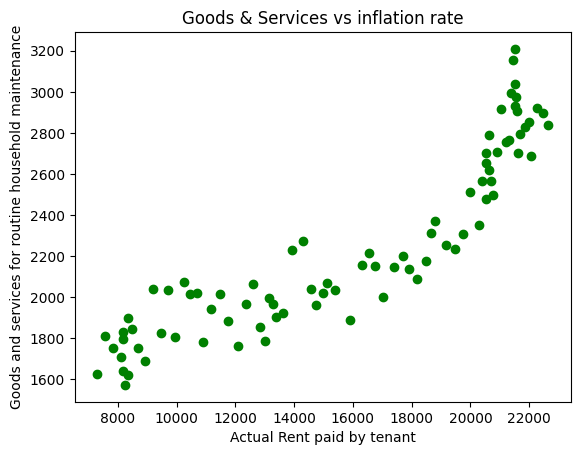

In [29]:
# Prepare Data
X= df_merged[['Actual rentals paid by tenants']]
y= df_merged['Goods and services for routine household maintenance']

# Visualise the Actual rentals paid by tenants and the number of goods and services for household maintenance
plt.scatter(X,y,color = 'g')
plt.title('Goods & Services vs inflation rate')
plt.xlabel('Actual Rent paid by tenant')
plt.ylabel('Goods and services for routine household maintenance')
plt.show()

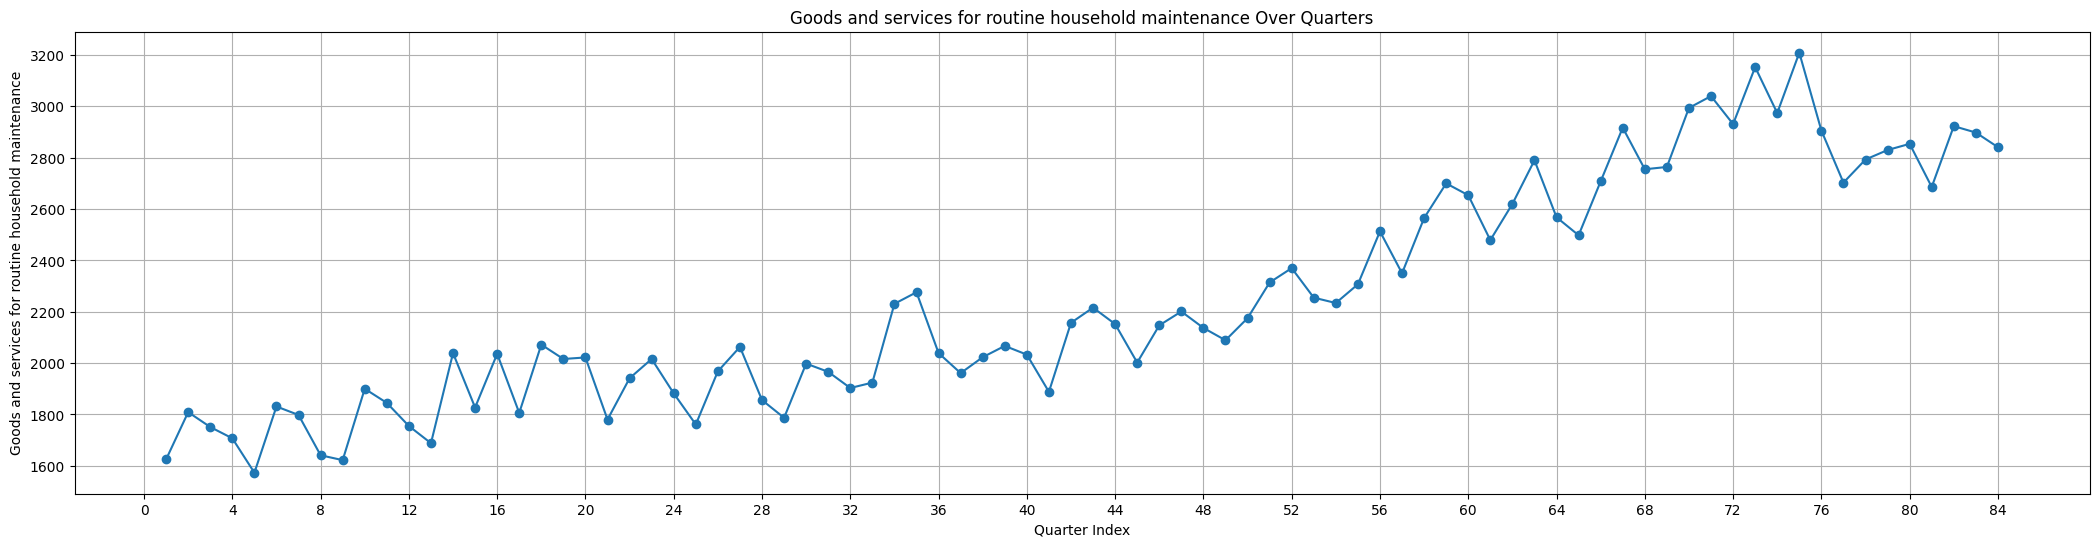

In [30]:
import seaborn as sns

quarter_to_index = {
    '2002 Q1': 1, '2002 Q2': 2, '2002 Q3': 3, '2002 Q4': 4,
    '2003 Q1': 5, '2003 Q2': 6, '2003 Q3': 7, '2003 Q4': 8,
    '2004 Q1': 9, '2004 Q2': 10, '2004 Q3': 11, '2004 Q4': 12,
    '2005 Q1': 13, '2005 Q2': 14, '2005 Q3': 15, '2005 Q4': 16,
    '2006 Q1': 17, '2006 Q2': 18, '2006 Q3': 19, '2006 Q4': 20,
    '2007 Q1': 21, '2007 Q2': 22, '2007 Q3': 23, '2007 Q4': 24,
    '2008 Q1': 25, '2008 Q2': 26, '2008 Q3': 27, '2008 Q4': 28,
    '2009 Q1': 29, '2009 Q2': 30, '2009 Q3': 31, '2009 Q4': 32,
    '2010 Q1': 33, '2010 Q2': 34, '2010 Q3': 35, '2010 Q4': 36,
    '2011 Q1': 37, '2011 Q2': 38, '2011 Q3': 39, '2011 Q4': 40,
    '2012 Q1': 41, '2012 Q2': 42, '2012 Q3': 43, '2012 Q4': 44,
    '2013 Q1': 45, '2013 Q2': 46, '2013 Q3': 47, '2013 Q4': 48,
    '2014 Q1': 49, '2014 Q2': 50, '2014 Q3': 51, '2014 Q4': 52,
    '2015 Q1': 53, '2015 Q2': 54, '2015 Q3': 55, '2015 Q4': 56,
    '2016 Q1': 57, '2016 Q2': 58, '2016 Q3': 59, '2016 Q4': 60,
    '2017 Q1': 61, '2017 Q2': 62, '2017 Q3': 63, '2017 Q4': 64,
    '2018 Q1': 65, '2018 Q2': 66, '2018 Q3': 67, '2018 Q4': 68,
    '2019 Q1': 69, '2019 Q2': 70, '2019 Q3': 71, '2019 Q4': 72,
    '2020 Q1': 73, '2020 Q2': 74, '2020 Q3': 75, '2020 Q4': 76,
    '2021 Q1': 77, '2021 Q2': 78, '2021 Q3': 79, '2021 Q4': 80,
    '2022 Q1': 81, '2022 Q2': 82, '2022 Q3': 83, '2022 Q4': 84
}

# Step 1: Replacing the 'Date' with the corresponding quarter index
df_merged['Quarter_Index'] = df_merged['Date'].map(quarter_to_index)

# Step 2: Plotting the data using the quarter indexes
plt.figure(figsize=(26, 6))
plt.plot(df_merged['Quarter_Index'], df_merged['Goods and services for routine household maintenance'], marker='o')
plt.title('Goods and services for routine household maintenance Over Quarters')
plt.xlabel('Quarter Index')
plt.ylabel('Goods and services for routine household maintenance')
plt.xticks(np.arange(0, 85, 4))
plt.grid(True)
plt.show()

----------------

### **Kneighbors Regressor**
##### As the data is continuous we use Kneighbor regression 
With this model we can predict amounts of (£) for Goods and services for routine household maintenance per each quarter of the year

Mean Squared Error: 15605.625
R² Score: 0.9285470994723288


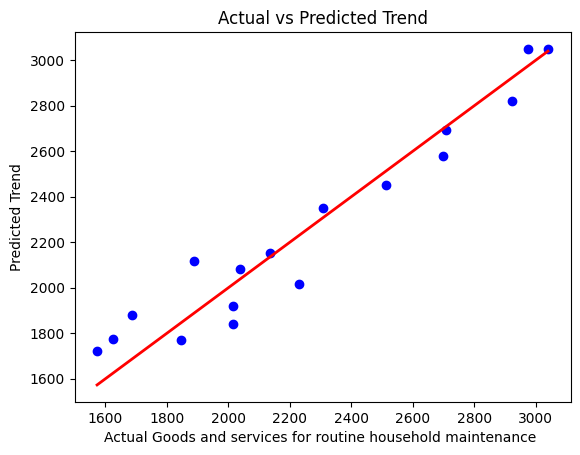

In [38]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prepare Data
X= df_merged[['Actual rentals paid by tenants']]
y= df_merged['Goods and services for routine household maintenance']

# Step 1: Prepapre Data (Train-test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Step 2: Initialise KNeighborsRegressor
knn_reg = KNeighborsRegressor(n_neighbors=4)

# Step 3: Fit the model on training data
knn_reg.fit(X_train, y_train)

# Step 4: Predict on test data
y_pred = knn_reg.predict(X_test)

'''
Modularise the knn code by creating a reusable function
Reusable knn function
'''
def train_model(X_train, y_train, model_type='knn'):
    if model_type == 'knn':
        model = KNeighborsRegressor(n_neighbors=4)
    elif model_type =='linear':
        model = LinearRegression()
    else:
        raise ValueError('Unknown model type')
    
    model.fit(X_train, y_train)
    return model

# Step 5: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Visualise predictions vs actuals
plt.scatter(y_test, y_pred, color='b', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Goods and services for routine household maintenance ')
plt.ylabel('Predicted Trend')
plt.title('Actual vs Predicted Trend')
plt.show()

In [35]:
# An example to test the model: Predict the trend for a new rental value
rentals_paid = [[9000], [16500], [21000]] 

# Predict how much household services and products could be sold
predicted_trend = knn_reg.predict(rentals_paid)

# Print the result
print(predicted_trend)

[1880.25 2131.75 2733.5 ]


c:\Users\mehrd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [56]:
# Save the model
joblib.dump(knn_reg, 'knn_reg_model.pk1')

['knn_reg_model.pk1']

----------

#
### **Linear Regression**
* X is independent variable **'Actual rental paid by tenants'** and y is dependent **'Goods and services for routine household maintenance'**
* Intercept and Coefficient are printed to to explain the nature of the relationship

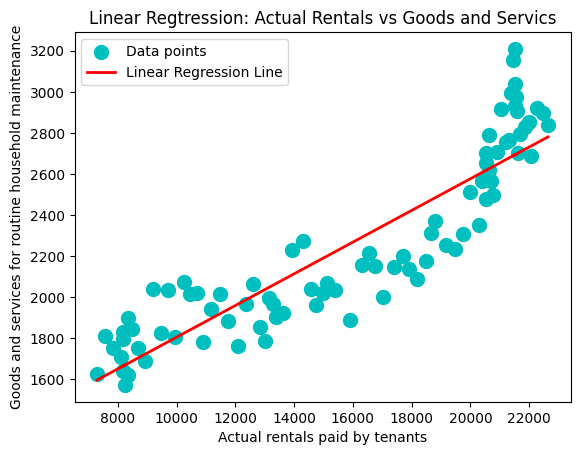

Intercept: 1033.933396935838
Coefficient: 0.07714918903345797


In [39]:
# Create the model  
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()

# Prepare Data
X= df_merged[['Actual rentals paid by tenants']]
y= df_merged['Goods and services for routine household maintenance']

# Fit the model
linear_reg.fit(X, y)

# Make predictions
y_pred_linear = linear_reg.predict(X)

# Plot the regression line and scatter plot
plt.scatter(X, y, color='c', s=100, label='Data points')
plt.plot(X, y_pred_linear, color='red', linewidth=2, label='Linear Regression Line')
plt.title('Linear Regtression: Actual Rentals vs Goods and Servics')
plt.xlabel('Actual rentals paid by tenants')
plt.ylabel('Goods and services for routine household maintenance')
plt.legend()
plt.show()

# Pirnt the intercept and coefficient 
print(f"Intercept: {linear_reg.intercept_}")
print(f"Coefficient: {linear_reg.coef_[0]}")

In [58]:
# Save the model
joblib.dump(linear_reg, 'linear_model.pk1')

['linear_model.pk1']

### Compare LinearRegression and KNN Model

KNN Results:
Mean Squared Error (KNN): 15605.625
R² Score (KNN): 0.9285470994723288

Linear Regression Results:
Mean Squared Error (Linear): 37222.60950685936
R² Score (Linear): 0.8295702085322461



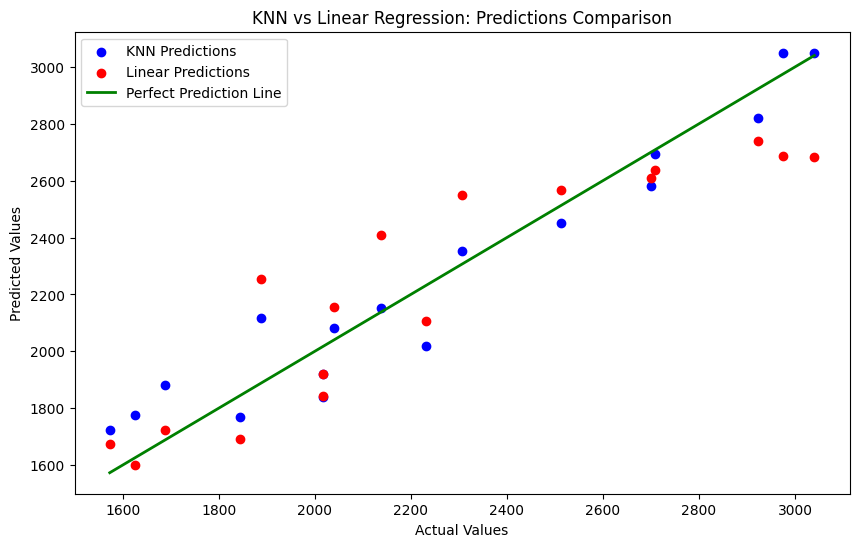

In [40]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Prepare Data
X = df_merged[['Actual rentals paid by tenants']]
y = df_merged['Goods and services for routine household maintenance']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN Model
knn_reg = KNeighborsRegressor(n_neighbors=4)
knn_reg.fit(X_train, y_train)
y_pred_knn = knn_reg.predict(X_test)

# Linear Regression Model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_linear = linear_reg.predict(X_test)

# Evaluate KNN
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

# Evaluate Linear Regression
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Print the comparison results
print("KNN Results:")
print(f"Mean Squared Error (KNN): {mse_knn}")
print(f"R² Score (KNN): {r2_knn}\n")

print("Linear Regression Results:")
print(f"Mean Squared Error (Linear): {mse_linear}")
print(f"R² Score (Linear): {r2_linear}\n")

# Visualize comparison
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_knn, label='KNN Predictions', color='b')
plt.scatter(y_test, y_pred_linear, label='Linear Predictions', color='r')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='g', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('KNN vs Linear Regression: Predictions Comparison')
plt.legend()
plt.show()


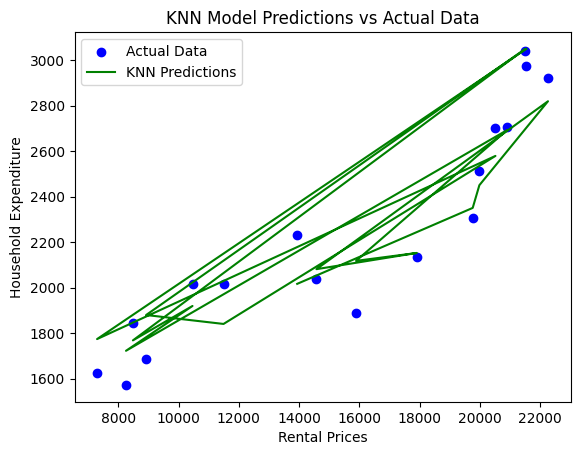

In [53]:
# Compare the actual data 
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.plot(X_test, y_pred_knn, color='green', label='KNN Predictions')
plt.title('KNN Model Predictions vs Actual Data')
plt.xlabel('Rental Prices')
plt.ylabel('Household Expenditure')
plt.legend()
plt.show()

--------

### **Logistic Regression**
While the dataframe contains continuous data and Logistic Regression is suitable for classification, we can classify the values of 'Goods and Services for routine household maintenance' into two categories 'Low = 0' and 'High = 1' (based on the median line)

* X is independent variable **'Actual rental paid by tenants'** and y is dependent **'Goods and services for routine household maintenance'**
* Intercept and Coefficient are printed to to explain the increase in rent will result a 'High' in goods and services. 
#

--------------

84    22781.767487
85    22943.556402
86    23101.522709
87    23237.484288
88    23343.095203
89    23488.421289
90    23637.297222
91    23770.984219
Name: predicted_mean, dtype: float64


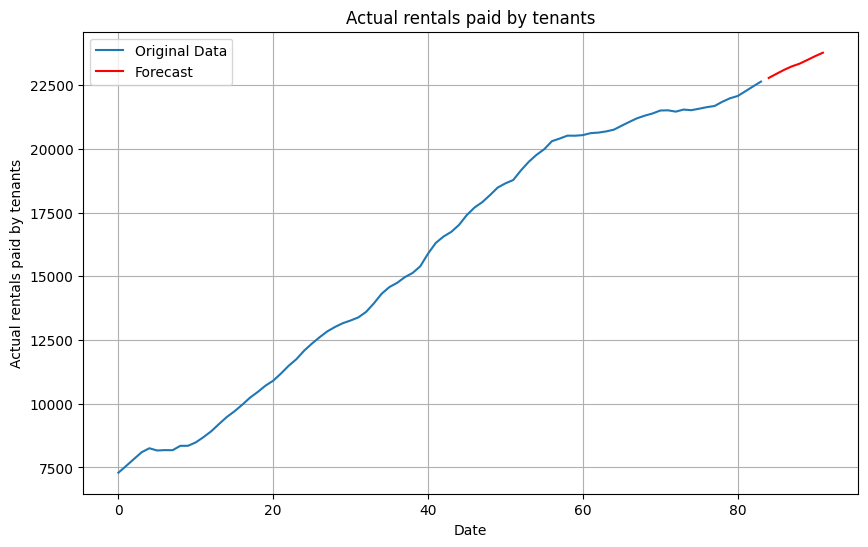

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a SARIMA model (for quarterly data, with seasonal order of 4)
sarima_model = SARIMAX(df_merged['Actual rentals paid by tenants'], order=(1,1,1), seasonal_order=(1,1,1,4))
sarima_fit = sarima_model.fit()

# Forecasting for the next 8 quarters (2 years)
forecast = sarima_fit.forecast(steps=8)
print(forecast)

# Plot the original data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(df_merged['Actual rentals paid by tenants'], label='Original Data')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Actual rentals paid by tenants')
plt.xlabel('Date')
plt.ylabel('Actual rentals paid by tenants')
plt.legend()
plt.grid(True)
plt.show()

84    2743.233069
85    2906.906985
86    2961.668020
87    2885.584641
88    2794.498840
89    2949.601353
90    3014.133278
91    2935.715911
Name: predicted_mean, dtype: float64


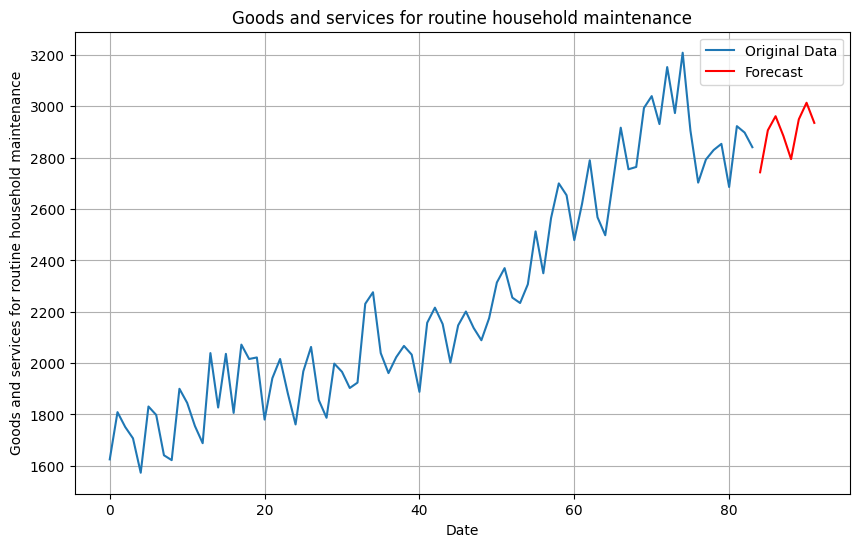

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a SARIMA model (for quarterly data, with seasonal order of 4)
sarima_model = SARIMAX(df_merged['Goods and services for routine household maintenance'], order=(1,1,1), seasonal_order=(1,1,1,4))
sarima_fit = sarima_model.fit()

# Forecasting for the next 8 quarters (2 years)
forecast = sarima_fit.forecast(steps=8)
print(forecast)

# Plot the original data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(df_merged['Goods and services for routine household maintenance'], label='Original Data')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Goods and services for routine household maintenance')
plt.xlabel('Date')
plt.ylabel('Goods and services for routine household maintenance')
plt.legend()
plt.grid(True)
plt.show()


--------------

### Database Deployment

In [43]:
# Create a connection to the databse
import sqlite3

# Connect to the sqlite3 database (create a file)
conn = sqlite3.connect('Housing Expenditure Trends.db')

# Create a cursor object to interact with the database 
cursor = conn.cursor()
cursor.execute("PRAGMA foreign_keys = ON;")

In [44]:
# Create tables in the database
cursor.execute('''
CREATE TABLE IF NOT EXISTS housing_indicators (
    Date TEXT PRIMARY KEY,
    Housing_Cost_Index REAL,
    Interest_Rate REAL,
    Inflation_Rate REAL,
    Employment_Levels INTEGER,
    Growth_in_Wage REAL,
    GDP_Growth_Rate REAL
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS householding_expenditure (
    Date TEXT,
    Goods_Services REAL,
    FOREIGN KEY(Date) REFERENCES housing_indicators(Date)
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS rentals (
    Date TEXT,
    Actual_Rentals REAL,
    FOREIGN KEY(Date) REFERENCES housing_indicators(Date)
    )
''')

# Commit the changes
conn.commit()

In [45]:
# Insert data from df_merged (housing and goods/services trends) into the Tables

for index, row in df_merged.iterrows():
    
    # Insert into the housing_indicators table
    cursor.execute('''
    INSERT OR REPLACE INTO housing_indicators 
    (Date, Housing_Cost_Index, Interest_Rate, Inflation_Rate, Employment_Levels, Growth_in_Wage, GDP_Growth_Rate)
    VALUES (?, ?, ?, ?, ?, ?, ?)''', 
    (row['Date'], row['Housing Cost Index'], row['Interest Rate (%)'], row['Inflation Rate (%)'], row['Employment Levels (000s)'], row['Growth in Wage (%)'], row['GDP Growth Rate (%)']))

    # Insert into the householding_expenditure table
    cursor.execute('''
    INSERT OR REPLACE INTO householding_expenditure 
    (Date, Goods_Services)
    VALUES (?, ?)''', 
    (row['Date'], row['Goods and services for routine household maintenance']))

    # Insert into the rentals table
    cursor.execute('''
    INSERT OR REPLACE INTO rentals 
    (Date, Actual_Rentals)
    VALUES (?, ?)''', 
    (row['Date'], row['Actual rentals paid by tenants']))

# Commit the changes
conn.commit()

In [46]:
# Query data from the database
cursor.execute('SELECT * FROM housing_indicators LIMIT 5')
rows = cursor.fetchall()
for row in rows:
    print(row)

cursor.execute('SELECT * FROM householding_expenditure LIMIT 5')
rows = cursor.fetchall()
for row in rows:
    print(row)

cursor.execute('SELECT * FROM rentals LIMIT 5')
rows = cursor.fetchall()
for row in rows:
    print(row)

('2002 Q1', 315.0920758491111, 2.691776039185554, 3.0136690834194275, 31439.99543239016, 6.256034570243844, -0.8307066446933509)
('2002 Q2', 630.9131687201436, 0.7491720537462448, 4.197641595636171, 26561.525973661905, 4.9620389232975874, 3.154814105459484)
('2002 Q3', 959.070766101024, 3.267249422190482, 4.4943144964271085, 25270.95992503484, 5.390080762795318, 3.90919314278438)
('2002 Q4', 1253.2719550590723, 1.3961393489478633, 2.107510592588815, 31718.927435987283, 6.39314993177579, 4.07789896359281)
('2003 Q1', 1502.3284179750003, 0.6458122079789199, 1.7380840774255093, 32999.1608537319, 6.2529086454712095, -0.1117527193810725)
('2002 Q1', 1625.0)
('2002 Q2', 1809.0)
('2002 Q3', 1751.0)
('2002 Q4', 1707.0)
('2003 Q1', 1573.0)
('2002 Q1', 7293.0)
('2002 Q2', 7558.0)
('2002 Q3', 7828.0)
('2002 Q4', 8095.0)
('2003 Q1', 8253.0)


In [47]:
# Add Error Handling and Logging for database operations and model training when querying or inserting data
import logging
logging.basicConfig(level=logging.INFO)

try:
    # Database operations
    cursor.execute('SELECT * FROM model_performance')
    logging.info("Model performance quieried successfully.")
except expception as e:
    logging.error(f"Error querying database:{e}")

INFO:root:Model performance quieried successfully.


In [48]:
# Close the connection 
conn.close()

In [49]:
# Connect to the SQLite database
conn = sqlite3.connect('Housing Expenditure Trends.db')
cursor = conn.cursor()

# Create a table to store model performance if not exists
cursor.execute('''
CREATE TABLE IF NOT EXISTS model_performance (
    model_name TEXT,
    mse REAL,
    r2_score REAL
)
''')

# Insert the performance of KNN and Linear Regression models
cursor.execute('''
INSERT INTO model_performance (model_name, mse, r2_score)
VALUES (?, ?, ?)''', ('KNN', mse_knn, r2_knn))

cursor.execute('''
INSERT INTO model_performance (model_name, mse, r2_score)
VALUES (?, ?, ?)''', ('Linear Regression', mse_linear, r2_linear))

# Commit and close
conn.commit()
conn.close()

print("Model performance has been stored in the database.")


OperationalError: database is locked

In [38]:
# Connect to the SQLite database and query the model performance
conn = sqlite3.connect('Housing Expenditure Trends.db')
cursor = conn.cursor()

cursor.execute('SELECT * FROM model_performance')
rows = cursor.fetchall()

for row in rows:
    print(row)

# Close the connection
conn.close()


('KNN', 15605.625, 0.9285470994723288)
('Linear Regression', 37222.60950685936, 0.8295702085322461)
